### Data Mining and Machine Learning

### Feature Selection in Supervised Classification

### Edgar Acuna

#### September 2021

##### Modules required: feature_selection from scikit-learn, feature selection from Arizona State University , skrebate, Orange and mRMR 
##### Datasets: Diabetes, Bupa, Breast-Cancer-Wisconsin, vehicle, Landsat, Loan and Heart-Cleveland


In [145]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import math as m
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, SelectPercentile, f_classif, mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Example 1: Diabetes dataset

In [146]:
url= "http://academic.uprm.edu/eacuna/diabetes.dat"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
data = pd.read_table(url, names=names,header=None)
y=data['class']
X=data.iloc[:,0:8]


### I. Feature Selection by Visualization using boxplots

In [147]:
print(data.shape)
data.head()
#normalizando los datos
data1=data.drop('class',axis=1)
data1_norm=(data1 - data1.min()) / (data1.max() - data1.min())
data1_norm['class']=data['class']

(768, 9)


<Figure size 720x3600 with 0 Axes>

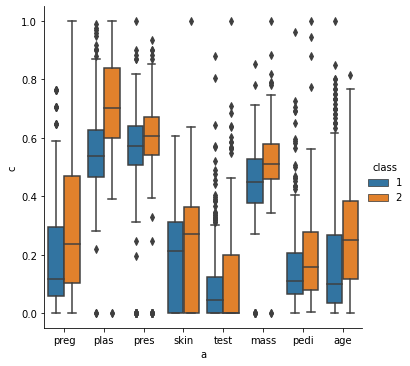

In [148]:
plt.figure(figsize=(10,50))
df_long = pd.melt(data1_norm, "class", var_name="a", value_name="c")
sns.factorplot("a", hue="class", y="c", data=df_long, kind="box")

Comment: From the boxplots we can see  that features: plas, age,mass, preg,and pedi have boxplot not so overlaped

## II-Feature selection using statistical measures

### II-1 Using the Chi-Square test  
It is desirable to have discretized attributes and two classes. I do not recommend 
to use this method because the Chi-Square test is approximated and it is not robust.

In [149]:
y=data['class']
X=data.iloc[:,0:8]

In [150]:
# Funcion auxiliar para discretizar cualquier columna de un dataframe
def disc_col_ew(df,str,k,out):
    df1=df[str]
    bins=np.linspace(df1.min(), df1.max(),k)
    if out=="num":
        df1=pd.cut(df1,bins=bins,include_lowest=True, right=True,labels=False)
    else:
        bins[0]=float('-inf')
        bins[k-1]=float('inf')
        df1=pd.cut(df1,bins=bins,include_lowest=True, right=True)  
    return df1
# funcion auxiliar para determinar el numero optimo de intervalos segun la formula de scott
def nclass_scott(x):
    h=3.5*(np.var(x,ddof=1)**.5)*len(x)**(-.3333)
    intervals=m.ceil((max(x)-min(x))/h)
    return int(intervals)

In [151]:
#Funcion para discretizar todas las colunmnas de un dataframe
def disc_ew(df,out):
    name=df.columns.tolist()
    disc=pd.DataFrame()
    for name in df.columns.tolist():
        k=nclass_scott(df[name])
        disc[name]=disc_col_ew(df,name,k,out)
    return disc

In [152]:
#discretizando las columnas de la matriz predictora X de diabetes
diab_disc=disc_ew(X,out="num")

In [153]:
#Choosing the best three features with Chi-square and scikit-learn
y1=y.to_numpy()
X1=diab_disc.to_numpy()
test = SelectKBest(score_func=chi2, k=3)
fit = test.fit(X1, y1)
# summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)
#Ranking the features according to their scores 
idx = np.argsort(fit.scores_)
print(X.columns[idx[::-1]])

[105.387 120.206   2.87   10.086  59.232  42.746  62.639 115.924]
Index(['plas', 'age', 'preg', 'pedi', 'test', 'mass', 'skin', 'pres'], dtype='object')


In [154]:
#Printing the subset containing the best three fetaures
features= fit.transform(X1)
print(features)

[[ 4 11  6]
 [ 0  6  2]
 [ 6 14  2]
 ...
 [ 3  9  1]
 [ 0 10  5]
 [ 0  7  0]]


Comentario: Las tres mejores variables con la prueba de Chi-square son plas, age y preg por tener el Chi-Square mas alto.

### II-2 Using the F test to find the best features  

Either  scikit-learn or the ASU library can be used

In [155]:
# Selecion  de Features usando los p-values de la F-test como score
# Aqui usamos scikit-learn y se selecciona el 30% de deatures con el mas alto score
selector = SelectPercentile(f_classif, percentile=30)
fit=selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
print(scores)
features= fit.transform(X)
# Imprime los datos de las tres mejores features
print(features)

[0.221 1.    0.027 0.034 0.084 0.378 0.14  0.253]
[[148.   33.6  50. ]
 [ 85.   26.6  31. ]
 [183.   23.3  32. ]
 ...
 [121.   26.2  30. ]
 [126.   30.1  47. ]
 [ 93.   30.4  23. ]]


Comentario: Las tres, mejores variables con la prueba de F son plas,mass y age

In [156]:
import numpy as np
from sklearn.feature_selection import f_classif


def f_score(X, y):
    """
    This function implements the anova f_value feature selection (existing method for classification in scikit-learn),
    where f_score = sum((ni/(c-1))*(mean_i - mean)^2)/((1/(n - c))*sum((ni-1)*std_i^2))
    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y : {numpy array},shape (n_samples,)
        input class labels
    Output
    ------
    F: {numpy array}, shape (n_features,)
        f-score for each feature
    """

    F, pval = f_classif(X, y)
    return F

In [157]:
def feature_ranking(F):
    """
    Rank features in descending order according to f-score, the higher the f-score, the more important the feature is
    """
    idx = np.argsort(F)
    return idx[::-1]

In [158]:
scoref =f_score(X, y)
idx = feature_ranking(scoref)
print(scoref,idx)

[ 39.67  213.162   3.257   4.304  13.281  71.772  23.871  46.141] [1 5 7 0 6 4 3 2]


Comentario: las tres variables mas importantes con la prueba de F son: plas,mass y age

## III Uaing Information measures

### Usando Mutual Information (Entropia)

Using the  scikit-learn module


In [159]:
# Univariate feature selection with Mutual Information
scores = mutual_info_classif(X,y)
scores /= scores.max()
print(scores)
#Ranking the features according to their scores 
idx = np.argsort(scores)
print(X.columns[idx[::-1]])

[0.38  1.    0.    0.223 0.295 0.665 0.104 0.731]
Index(['plas', 'age', 'mass', 'preg', 'test', 'skin', 'pedi', 'pres'], dtype='object')



Comentario: Las tres variables usando el criterio de Mutual Information son: plas, mass y age

## IV-Using ReliefF to select the best features 

#### IV-1 Usando el modulo skrebate 

In [160]:
from skrebate import ReliefF

df=data.drop('class',axis=1)
#Normalizando las predictoras
df_norm=(df - df.min()) / (df.max() - df.min())
features, labels = df_norm.values, data['class'].values
features

array([[0.353, 0.744, 0.59 , ..., 0.501, 0.234, 0.483],
       [0.059, 0.427, 0.541, ..., 0.396, 0.117, 0.167],
       [0.471, 0.92 , 0.525, ..., 0.347, 0.254, 0.183],
       ...,
       [0.294, 0.608, 0.59 , ..., 0.39 , 0.071, 0.15 ],
       [0.059, 0.633, 0.492, ..., 0.449, 0.116, 0.433],
       [0.059, 0.467, 0.574, ..., 0.453, 0.101, 0.033]])

In [161]:
fs = ReliefF(n_neighbors=10)
fs.fit(features, labels)
for feature_name, feature_score in zip(data.columns,fs.feature_importances_):
    print (feature_name, feature_score)

preg 0.011557904411764679
plas 0.027526957705192593
pres 0.005626707650273222
skin 0.012511837121212118
test 0.004258551270685579
mass 0.015538065076999513
pedi 0.007962389695417026
age 0.009900173611111106


In [180]:
yscore=fs.feature_importances_
oyscore=-np.sort(-yscore)
print(oyscore)

[0.028 0.016 0.013 0.012 0.01  0.008 0.006 0.004]


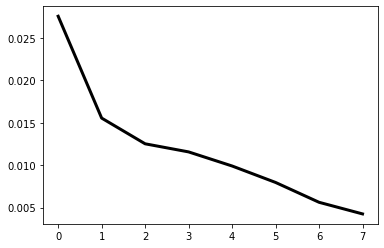

In [178]:
import matplotlib.pyplot as plt
x=np.arange(0,8)
plt.plot(x,oyscore,'k-',lw=3)

Comentario: las tres variables mas importantes con el ReliefF son: plas,mass y skin

#### IV-2 Usando el Relief de Orange

In [107]:
import Orange
df = Orange.data.Table("https://academic.uprm.edu/eacuna/diabetes.tab")
#ReliefF usando 10 vecinos mas cercanos y  una muestrd m=100 para updating de los pesos
print('Feature scores for best  features (scored individually):')
meas =Orange.preprocess.score.ReliefF(n_iterations=400,k_nearest=10)
scores = meas(df)
for attr, score in zip(df.domain.attributes, scores):
    print('%.3f' % score, attr.name)

Feature scores for best  features (scored individually):
0.017 preg
0.025 plas
0.006 pres
0.013 skin
0.006 test
0.017 mass
0.007 pedi
0.011 age


In [108]:
#Ranking the features according to their scores 
idx = np.argsort(scores)
print(X.columns[idx[::-1]])

Index(['plas', 'mass', 'preg', 'skin', 'age', 'pedi', 'pres', 'test'], dtype='object')


The best features are: plas, mass and skin.

### Example 2:  Bupa dataset

In [109]:
#load data
url= "http://academic.uprm.edu/eacuna/bupa.dat"
names = ['mcv', 'alkphos', 'sgpt', 'aspar', 'gammagt', 'drinks', 'class']
data = pd.read_table(url, names=names,header=None)
y=data['class']
X=data.iloc[:,0:6]
y1=y.to_numpy()
X1=X.to_numpy()
features, labels = X.values, data['class'].values

#### Using skrebate

In [110]:
df=data.drop('class',axis=1)
#Normalizando las predictoras
df_norm=(df - df.min()) / (df.max() - df.min())
features, labels = df_norm.values, data['class'].values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mcv      345 non-null    int64  
 1   alkphos  345 non-null    int64  
 2   sgpt     345 non-null    int64  
 3   aspar    345 non-null    int64  
 4   gammagt  345 non-null    int64  
 5   drinks   345 non-null    float64
dtypes: float64(1), int64(5)
memory usage: 16.3 KB


In [111]:
fs = ReliefF(n_neighbors=10)
fs.fit(features, labels)
for feature_name, feature_score in zip(data.columns,fs.feature_importances_):
    print (feature_name, feature_score)

mcv 0.0028375286041189907
alkphos -0.0006200378071833658
sgpt 0.005445820136289467
aspar 0.0033427442123094295
gammagt 0.004875918205280923
drinks 0.00485507246376812


El relielf de skrebate recomienda gammagt, aspar and sgpt 

### Using the ReliefF from Orange

In [112]:
import Orange
df = Orange.data.Table("https://datasets.biolab.si/core/bupa.tab")
#ReliefF usando 10 vecinos mas cercanos y  una muestra de n=300 para updating de los pesos
print('Feature scores for best ten features (scored individually):')
meas =Orange.preprocess.score.ReliefF(n_iterations=300,k_nearest=10)
scores = meas(df)
for attr, score in zip(df.domain.attributes, scores):
    print('%.4f' % score, attr.name)

Feature scores for best ten features (scored individually):
0.0020 mcv
0.0003 alkphos
0.0059 sgpt
0.0026 sgot
0.0051 gammagt
0.0065 drinks


### Example 3: Breast-cancer-Wisconsin

In [181]:
names = [
    'ID','Clump', 'Unif_Cell_Size', 'Unif_Cell_Shape', 'Marginal_Adh', 'Single_Cell_Size', 'Bare_Nuclei', 'Bland_Chromatine', 'Normal_Nucleoi', 'Mitoses','class']
data = pd.read_table("https://academic.uprm.edu/eacuna/breast-cancer-wisconsin.data", names=names, header=None,sep=",",na_values="?")

In [182]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                699 non-null    int64  
 1   Clump             699 non-null    int64  
 2   Unif_Cell_Size    699 non-null    int64  
 3   Unif_Cell_Shape   699 non-null    int64  
 4   Marginal_Adh      699 non-null    int64  
 5   Single_Cell_Size  699 non-null    int64  
 6   Bare_Nuclei       683 non-null    float64
 7   Bland_Chromatine  699 non-null    int64  
 8   Normal_Nucleoi    699 non-null    int64  
 9   Mitoses           699 non-null    int64  
 10  class             699 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 60.2 KB


### Using skrebate

In [183]:
#Dropping the ID column
df=data.drop('ID',axis=1)

In [184]:
#Dropping the class column
df1=df.drop('class',axis=1)

In [185]:
#Normalizando las predictoras
df_norm=(df1 - df1.min()) / (df1.max() - df1.min())
features, labels = df_norm.values, df['class'].values

In [186]:
fs = ReliefF(n_neighbors=10)
fs.fit(features, labels)
for feature_name, feature_score in zip(df1.columns,fs.feature_importances_):
    print (feature_name, feature_score)

Clump 0.47682403433476367
Unif_Cell_Size 0.5374821173104439
Unif_Cell_Shape 0.5220314735336208
Marginal_Adh 0.20901287553648162
Single_Cell_Size 0.28183118741058716
Bare_Nuclei 0.5560857914935173
Bland_Chromatine 0.4718168812589402
Normal_Nucleoi 0.3017167381974248
Mitoses 0.06781115879828353


[0.556 0.537 0.522 0.477 0.472 0.302 0.282 0.209 0.068]


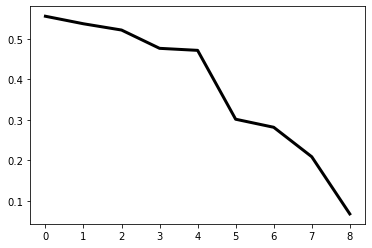

In [187]:
yscore=fs.feature_importances_
oyscore=-np.sort(-yscore)
print(oyscore)
x=np.arange(0,9)
plt.plot(x,oyscore,'k-',lw=3)

### Using Relief from Orange

In [119]:
import Orange
df = Orange.data.Table("https://academic.uprm.edu/eacuna/breast-cancer-wisconsin.tab")
#ReliefF usando 10 vecinos mas cercanos y  una muestrd m=400 para updating de los pesos
print('Feature scores for best ten features (scored individually):')
meas =Orange.preprocess.score.ReliefF(n_iterations=500,k_nearest=1)
scores = meas(df)
for attr, score in zip(df.domain.attributes, scores):
    print('%.3f' % score, attr.name)


Feature scores for best ten features (scored individually):
0.576 Clump
0.210 Unif_Cell_Size
0.212 Unif_Cell_Shape
0.128 Marginal_Adh
0.178 Single_Cell_Size
0.634 Bare_Nuclei
0.524 Bland_Chromatine
0.398 Normal_Nucleoi
0.038 Mitoses


Comment:The best attributes are:6(Bare Nuclei),1 (Clump Thickness),7 (Bland Chromatin), 8 (Normal. nucleoli)

## V. Relief for multiclass problem

### Example 4: The vehicle dataset

In [188]:
df1=pd.read_csv("http://academic.uprm.edu/eacuna/vehicle.csv")
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   COMPACTNESS                846 non-null    int64 
 1   CIRCULARITY                846 non-null    int64 
 2   DISTANCE_CIRCULARITY       846 non-null    int64 
 3   RADIUS_RATIO               846 non-null    int64 
 4   PR.AXIS_ASPECT_RATIO       846 non-null    int64 
 5   MAX.LENGTH_ASPECT_RATIO    846 non-null    int64 
 6   SCATTER_RATIO              846 non-null    int64 
 7   ELONGATEDNESS              846 non-null    int64 
 8   PR.AXIS_RECTANGULARITY     846 non-null    int64 
 9   MAX.LENGTH_RECTANGULARITY  846 non-null    int64 
 10  SCALED_VARIANCE_MAJOR      846 non-null    int64 
 11  SCALED_VARIANCE_MINOR      846 non-null    int64 
 12  SCALED_RADIUS_OF_GYRATION  846 non-null    int64 
 13  SKEWNESS_ABOUT_MAJOR       846 non-null    int64 
 14  SKEWNESS_A

In [189]:
#Convirtiendo en matriz la tabla de predictoras y la columna de clases
y=df1['Class']
X=df1.iloc[:,0:18]
y1=y.values
X1=X.values

In [190]:
#Normalizando las predictoras
X_norm=(X - X.min()) / (X.max() - X.min())
features, labels = X_norm.values, y1

### Using skrebate

In [191]:
fs = ReliefF(n_neighbors=10)
fs.fit(features, labels)
for feature_name, feature_score in zip(X.columns,fs.feature_importances_):
    print (feature_name, feature_score)

COMPACTNESS 0.03193373762291431
CIRCULARITY 0.039858762199187686
DISTANCE_CIRCULARITY 0.05037704666841779
RADIUS_RATIO 0.025719285205487937
PR.AXIS_ASPECT_RATIO 0.01771664112089645
MAX.LENGTH_ASPECT_RATIO 0.022408076482745284
SCATTER_RATIO 0.05649191118527783
ELONGATEDNESS 0.06308454351007536
PR.AXIS_RECTANGULARITY 0.05479051746782251
MAX.LENGTH_RECTANGULARITY 0.04912529550827419
SCALED_VARIANCE_MAJOR 0.04790158019161377
SCALED_VARIANCE_MINOR 0.05558470481298174
SCALED_RADIUS_OF_GYRATION 0.02899029097343028
SKEWNESS_ABOUT_MAJOR 0.020997158973082825
SKEWNESS_ABOUT_MINOR 0.02055842109033598
KURTOSIS_ABOUT_MAJOR 0.015962251821099775
KURTOSIS_ABOUT_MINOR 0.032209088521145256
HOLLOWS_RATIO 0.055018387181507755


In [192]:
idx = np.argsort(fs.feature_importances_)
print(X.columns[idx[::-1]])

Index(['ELONGATEDNESS', 'SCATTER_RATIO', 'SCALED_VARIANCE_MINOR',
       'HOLLOWS_RATIO', 'PR.AXIS_RECTANGULARITY', 'DISTANCE_CIRCULARITY',
       'MAX.LENGTH_RECTANGULARITY', 'SCALED_VARIANCE_MAJOR', 'CIRCULARITY',
       'KURTOSIS_ABOUT_MINOR', 'COMPACTNESS', 'SCALED_RADIUS_OF_GYRATION',
       'RADIUS_RATIO', 'MAX.LENGTH_ASPECT_RATIO', 'SKEWNESS_ABOUT_MAJOR',
       'SKEWNESS_ABOUT_MINOR', 'PR.AXIS_ASPECT_RATIO', 'KURTOSIS_ABOUT_MAJOR'],
      dtype='object')


[0.063 0.056 0.056 0.055 0.055 0.05  0.049 0.048 0.04  0.032 0.032 0.029
 0.026 0.022 0.021 0.021 0.018 0.016]


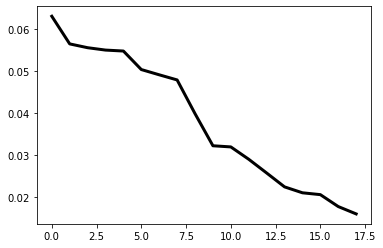

In [193]:
yscore=fs.feature_importances_
oyscore=-np.sort(-yscore)
print(oyscore)
x=np.arange(0,18)
plt.plot(x,oyscore,'k-',lw=3)

#### The best features are: 'ELONGATEDNESS', 'SCATTER_RATIO', 'SCALED_VARIANCE_MINOR', 'HOLLOWS_RATIO', 'PR.AXIS_RECTANGULARITY', 'DISTANCE_CIRCULARITY', 'MAX.LENGTH_RECTANGULARITY', 'SCALED_VARIANCE_MAJOR'

### Example 5: Landsat Dataset

In [125]:
names=['a1','a2','a3','a4','a5','a6','a7','a8','a9','a10','a11','a12','a13','a14','a15','a16','a17','a18','a19','a20','a21','a22','a23','a24','a25','a26','a27','a38','a29','a30','a31','a32','a33','a34','a35','a36','class']
url='http://academic.uprm.edu/eacuna/landsat.txt'
data = pd.read_csv(url,names=names, header=None,delim_whitespace=True)
data.head()

,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,...,a38,a29,a30,a31,a32,a33,a34,a35,a36,class
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,3
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,3
2,84,102,102,83,80,102,102,79,84,94,...,87,84,99,104,79,84,99,104,79,3
3,80,102,102,79,84,94,102,79,80,94,...,79,84,99,104,79,84,103,104,79,3
4,84,94,102,79,80,94,98,76,80,102,...,79,84,103,104,79,79,107,109,87,3


In [126]:
y=data['class']
X=data.iloc[:,0:36]
y1=y.to_numpy()
X1=X.to_numpy()
features, labels = X.values, data['class'].values

In [127]:
df=data.drop('class',axis=1)
#Normalizando las predictoras
df_norm=(df - df.min()) / (df.max() - df.min())
features, labels = df_norm.values, data['class'].values
df.shape

(4435, 36)

In [128]:
fs = ReliefF(n_neighbors=10)
fs.fit(features, labels)
for feature_name, feature_score in zip(data.columns,fs.feature_importances_):
    print (feature_name, feature_score)

a1 0.1069622322435175
a2 0.08774110894742236
a3 0.07384307725344937
a4 0.06579667744370023
a5 0.10794995817725539
a6 0.08131507635543732
a7 0.05711923099744859
a8 0.058862175873731784
a9 0.10868010146561434
a10 0.09375361478092464
a11 0.05726534148222859
a12 0.06833487175873718
a13 0.12038069607593539
a14 0.09942060532477634
a15 0.06825709524042949
a16 0.07309934458181229
a17 0.11442474633596403
a18 0.09748492245049895
a19 0.0705850776273073
a20 0.06438353452305638
a21 0.11473960627872665
a22 0.09845185582469541
a23 0.0573992734560943
a24 0.06574654340473508
a25 0.1161337373167984
a26 0.09818047003729063
a27 0.07100794360429735
a38 0.06982765877489654
a29 0.10944563350966978
a30 0.09954578231216593
a31 0.06022087462172895
a32 0.06062440107102592
a33 0.11183469560315669
a34 0.09558748262387678
a35 0.06061857236100407
a36 0.06521427564825252


In [129]:
idx = np.argsort(fs.feature_importances_)
print(df.columns[idx[::-1]])

Index(['a13', 'a25', 'a21', 'a17', 'a33', 'a29', 'a9', 'a5', 'a1', 'a30',
       'a14', 'a22', 'a26', 'a18', 'a34', 'a10', 'a2', 'a6', 'a3', 'a16',
       'a27', 'a19', 'a38', 'a12', 'a15', 'a4', 'a24', 'a36', 'a20', 'a32',
       'a35', 'a31', 'a8', 'a23', 'a11', 'a7'],
      dtype='object')


Comment:The best attributes are:a13,a25,a21,a17,a33,a29,a9,a5,a1,a30

### Using Relief from Orange

In [130]:
#Usando el Relief de Orange
import Orange
df = Orange.data.Table("https://academic.uprm.edu/eacuna/landsat.tab")
print('Feature scores  (scored individually):')
#ReliefF usando 10 vecinos mas cercanos y  una muestrd m=3000 para updating de los pesos
meas =Orange.preprocess.score.ReliefF(n_iterations=3000,k_nearest=10)
scores = meas(df)
for attr, score in zip(df.domain.attributes, scores):
    print('%.3f' % score, attr.name)


Feature scores  (scored individually):
0.113 a1
0.086 a2
0.075 a3
0.066 a4
0.114 a5
0.076 a6
0.055 a7
0.057 a8
0.109 a9
0.085 a10
0.056 a11
0.066 a12
0.124 a13
0.100 a14
0.072 a15
0.077 a16
0.122 a17
0.097 a18
0.073 a19
0.067 a20
0.118 a21
0.092 a22
0.059 a23
0.067 a24
0.119 a25
0.096 a26
0.076 a27
0.073 a28
0.113 a29
0.097 a30
0.063 a31
0.063 a32
0.117 a33
0.090 a34
0.062 a35
0.067 a36


In [131]:
idx = np.argsort(scores)
print(idx[::-1])

[12 16 24 20 32  4 28  0  8 13 17 29 25 21 33  1  9 15 26  5  2 18 27 14
 23 19 35 11  3 31 30 34 22  7 10  6]


Comment:The best attributes are:a13,a25,a17,a21,a33,a29,a1,a5,a9

## VI.  Applying Relief to a dataset with mixed type of attributes

#### VI-1 The Loan Dataset

In [132]:
import Orange
df = Orange.data.Table("https://academic.uprm.edu/eacuna/loan.tab")
df

[[Hombre, 3, No, 17, 2500, ... | No],
 [Mujer, 5, Si, 10, 3000, ... | Si],
 [Mujer, 4, No, 15, 2000, ... | No],
 [Hombre, 3, Si, 16, 2800, ... | Si],
 [Hombre, 6, Si, 11, 4000, ... | Si],
 ...
]

In [133]:
meas =Orange.preprocess.score.ReliefF(n_iterations=2000,k_nearest=10)
scores = meas(df)

In [134]:
for attr, score in zip(df.domain.attributes, scores):
    print('%.3f' % score, attr.name)

0.077 Sexo
-0.012 Familia
0.008 CasPropia
0.016 AnosEmpleo
0.056 Sueldo
0.127 StatustMarital


### VI-2 The Heart-Cleveland Dataset

In [135]:
#Usando el Relief de Orange
import Orange
df = Orange.data.Table("https://academic.uprm.edu/eacuna/heart_disease.tab")
print('Feature scores (scored individually):')
#ReliefF usando 10 vecinos mas cercanos y  una muestrd m=200 ara updating de los pesos
meas =Orange.preprocess.score.ReliefF(n_iterations=200,k_nearest=10)
scores = meas(df)
for attr, score in zip(df.domain.attributes, scores):
    print('%.3f' % score, attr.name)


Feature scores (scored individually):
0.011 age
0.096 gender
0.131 chest pain
0.014 rest SBP
0.000 cholesterol
0.024 fasting blood sugar > 120
0.062 rest ECG
0.021 max HR
0.054 exerc ind ang
0.025 ST by exercise
0.056 slope peak exc ST
0.078 major vessels colored
0.122 thal


In [136]:
idx = np.argsort(scores)
print(idx[::-1])

[ 2 12  1 11  6 10  8  9  5  7  3  0  4]


The best features are: chest pain, thal, major vessels colored, gender

### VII. Feature selection using Minumum Redudancy and Maximum Relevancy (mRMR)

#### mRMR applied to landsat

In [137]:
import pandas as pd
from mrmr import mrmr_classif


In [138]:
# Chhosing teh top ten best features 
mrmr = mrmr_classif(X,y, K = 36)

100%|██████████| 36/36 [00:04<00:00,  7.62it/s]


In [139]:
print(mrmr)

['a18', 'a20', 'a17', 'a16', 'a22', 'a21', 'a24', 'a14', 'a13', 'a8', 'a30', 'a32', 'a5', 'a6', 'a38', 'a29', 'a34', 'a12', 'a33', 'a4', 'a9', 'a2', 'a36', 'a10', 'a25', 'a1', 'a26', 'a19', 'a15', 'a23', 'a27', 'a7', 'a31', 'a3', 'a11', 'a35']
